In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
data = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv', low_memory=False)

In [70]:
data.shape

(20750, 650)

In [71]:
features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp', 'HeatFlow']
lat = data['LatDegree']
lon = data['LongDegree']
depth = data['MeasureDepth_m']
temp = data['SurfTemp']
heatf = data['HeatFlow']

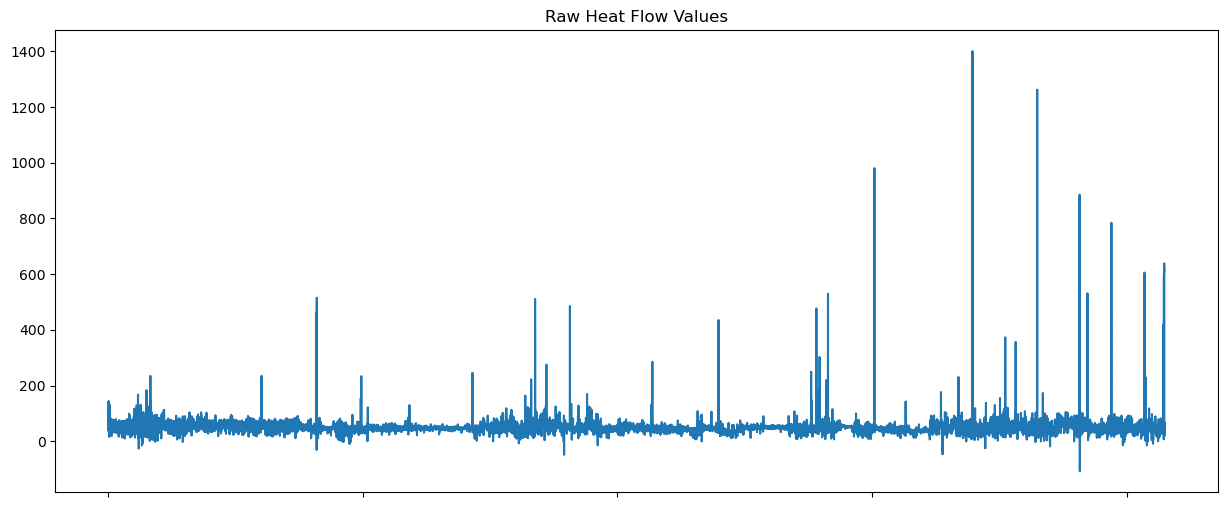

In [72]:
plt.figure(figsize=(15,6))
plt.title('Raw Heat Flow Values')
plt.plot(heatf)
ax = plt.gca()

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)

<Axes: xlabel='HeatFlow', ylabel='Density'>

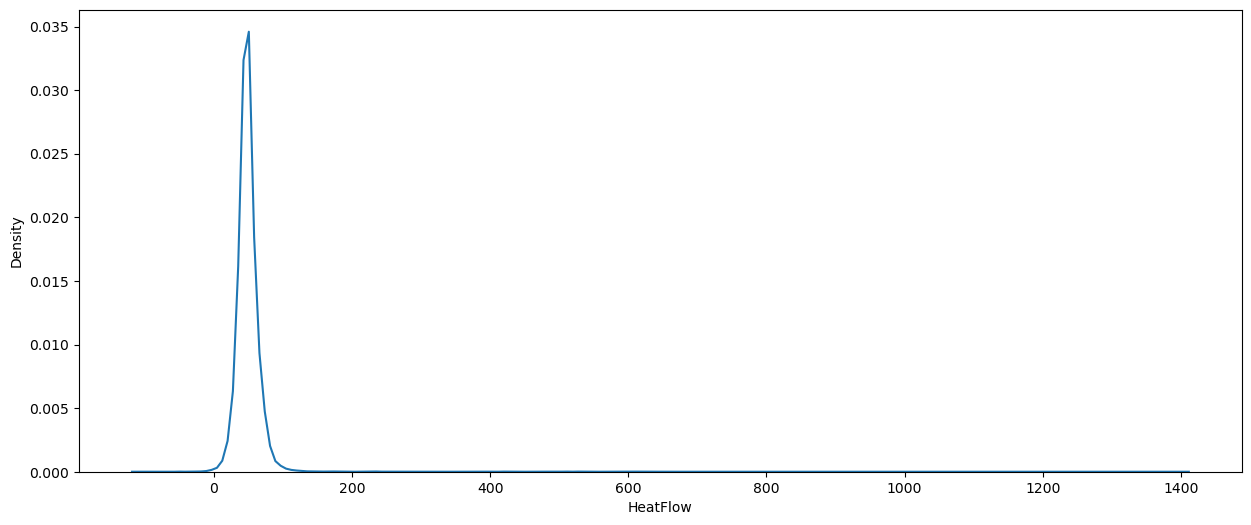

In [73]:
plt.figure(figsize=(15, 6))
sns.kdeplot(data=heatf)

# IQR Removal

In [74]:
def remove_outliers_iqr(data, column):
    # Calculate the first and third quartiles
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create masks for outliers and non-outliers
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    # Create a mask for non-outliers
    non_outliers_mask = (data[column] >= lower_bound) & (data[column] <= upper_bound)
    
    return data[non_outliers_mask].copy(), outliers_mask

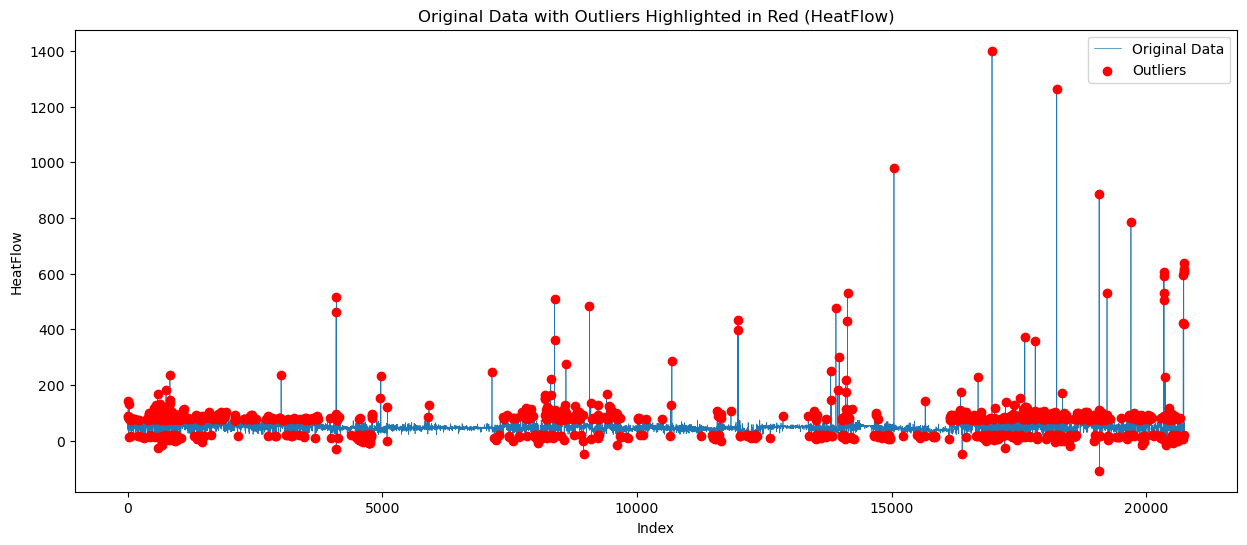

In [75]:
# Plot the original column values

data_iqr_removed = remove_outliers_iqr(data, 'HeatFlow')[0]
outliers_mask = remove_outliers_iqr(data, 'HeatFlow')[1]

column = 'HeatFlow'

plt.figure(figsize=(15, 6))
plt.plot(data.index, data[column], label='Original Data', linewidth=0.5)
    
# Highlight outliers in red
plt.scatter(data.index[outliers_mask], data[column][outliers_mask], color='red', label='Outliers', zorder=10)
    
plt.xlabel('Index')
plt.ylabel(column)
plt.legend()
plt.title(f'Original Data with Outliers Highlighted in Red ({column})')
plt.show()

In [76]:
data_iqr_removed = data_iqr_removed.reset_index(drop=True)

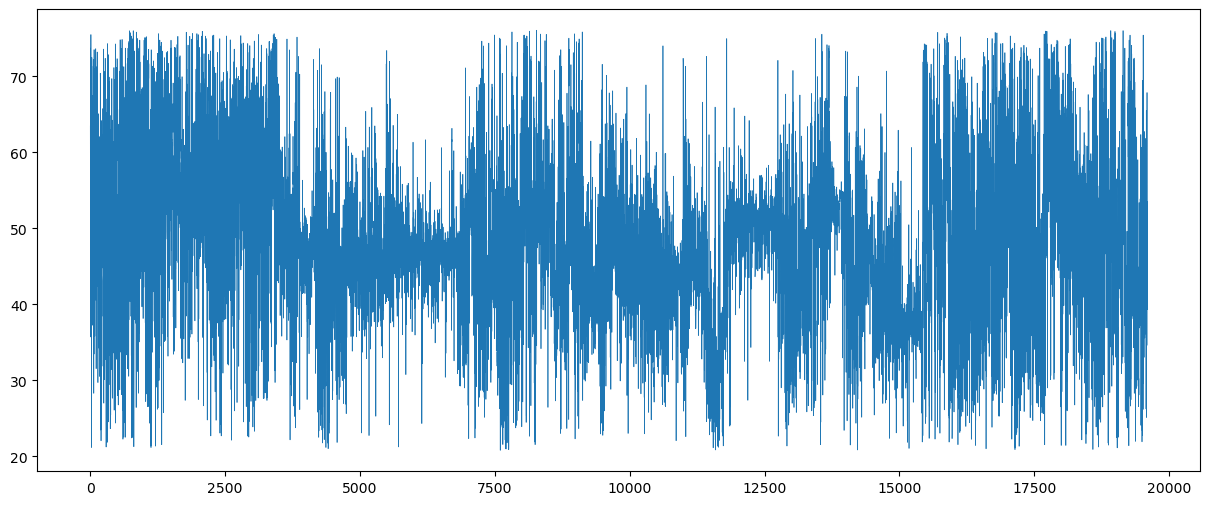

In [77]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(data_iqr_removed.HeatFlow)), data_iqr_removed.HeatFlow, linewidth=0.5)

# 3 sigma rule

In [78]:
def remove_outliers_3sigma(data, column):
    # Calculate the mean and standard deviation
    mean_value = data[column].mean()
    std_value = data[column].std()
    
    # Define the lower and upper bounds to identify outliers
    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value
    
    # Create masks for outliers and non-outliers
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    # Create a mask for non-outliers
    non_outliers_mask = (data[column] >= lower_bound) & (data[column] <= upper_bound)
    
    return data[non_outliers_mask].copy(), outliers_mask

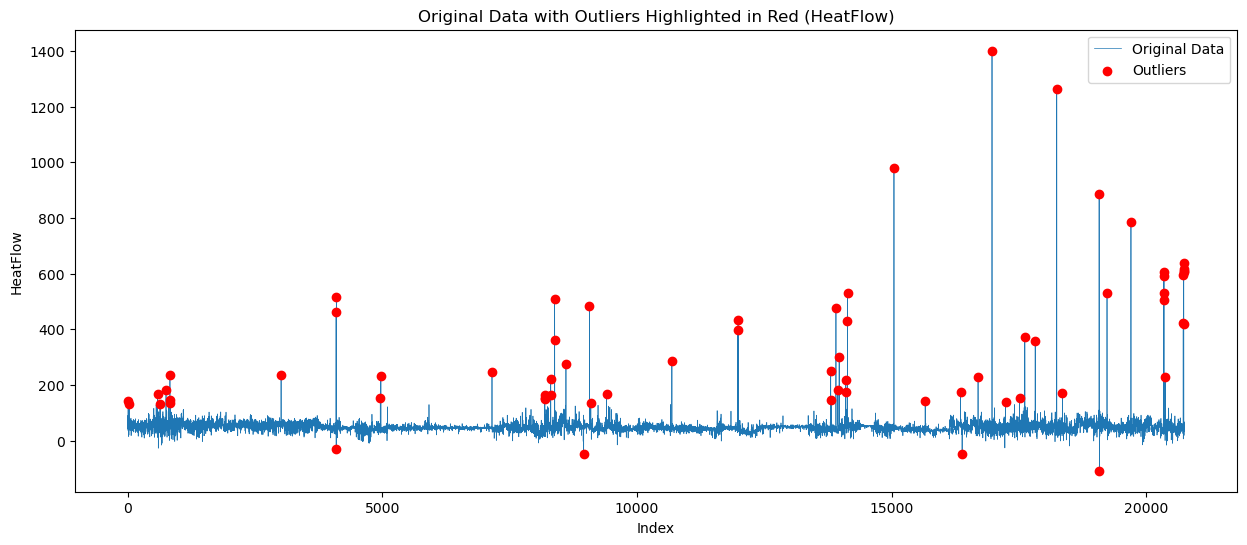

In [79]:
# Plot the original column values

data_sigma_removed = remove_outliers_3sigma(data, 'HeatFlow')[0]
outliers_mask = remove_outliers_3sigma(data, 'HeatFlow')[1]

column = 'HeatFlow'

plt.figure(figsize=(15, 6))
plt.plot(data.index, data[column], label='Original Data', linewidth=0.5)
    
# Highlight outliers in red
plt.scatter(data.index[outliers_mask], data[column][outliers_mask], color='red', label='Outliers', zorder=10)
    
plt.xlabel('Index')
plt.ylabel(column)
plt.legend()
plt.title(f'Original Data with Outliers Highlighted in Red ({column})')
plt.show()

In [80]:
data_sigma_removed = data_sigma_removed.reset_index(drop=True)

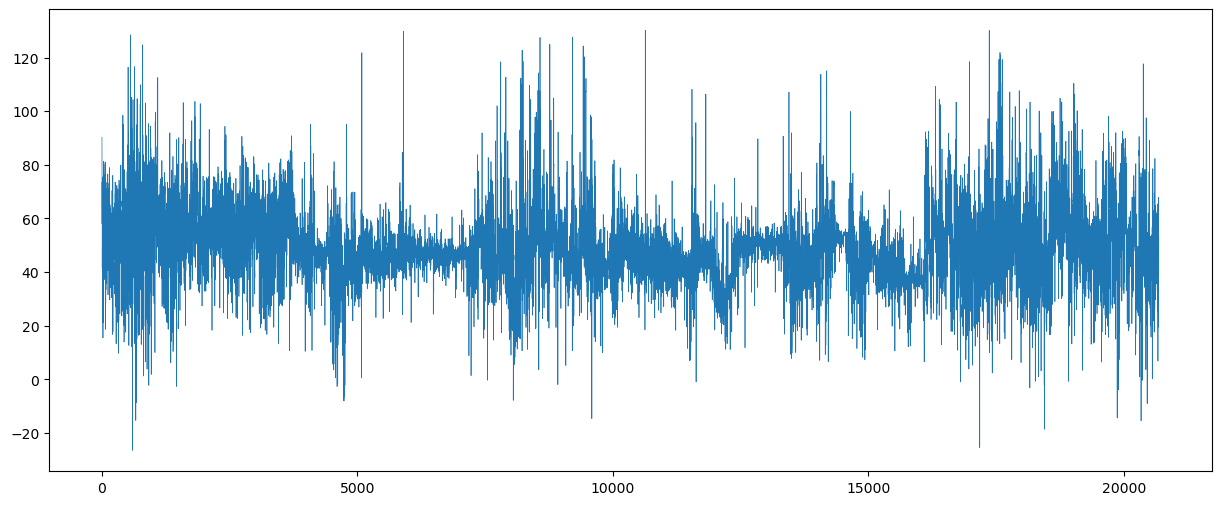

In [81]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(data_sigma_removed.HeatFlow)), data_sigma_removed.HeatFlow, linewidth=0.5)

# TUNING for LightGBM with IQR

In [120]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
scaleryyy = MinMaxScaler()

columns_to_normalize = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
yyy = ['CorrBHT']

# Normalize specific columns independently
data_iqr_removed[columns_to_normalize] = scaler.fit_transform(data_iqr_removed[columns_to_normalize])
data_iqr_removed[yyy] = scaleryyy.fit_transform(data_iqr_removed[yyy])

In [122]:
# Define features and target
features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
geological_layers = data_iqr_removed.iloc[:, 52:101].values
geological_conds = data_iqr_removed.iloc[:, 101:150].values
mult = np.multiply(geological_layers, geological_conds)
np.nan_to_num(mult, 0)
X = np.concatenate((data_iqr_removed[features].values, mult), axis=1)
y = data_iqr_removed['CorrBHT'].values

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [124]:
# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [126]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [10, 20, 30],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_child_samples': [5, 10, 20]
}

# Initialize variables to track the best hyperparameters and error
best_params = None
best_error = float('inf')

# Iterate through all combinations
for lr in param_grid['learning_rate']:
    for num_leaves in param_grid['num_leaves']:
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                for min_child_samples in param_grid['min_child_samples']:
                    # Create a LightGBM model with the current hyperparameters
                    model = lgb.LGBMRegressor(
                        learning_rate=lr,
                        num_leaves=num_leaves,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_child_samples=min_child_samples
                    )

                    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

                    # Make predictions on the validation data
                    y_pred_val = model.predict(X_val)

                    # Calculate the mean squared error on the validation set
                    error = mean_squared_error(scaleryyy.inverse_transform(y_val.reshape(-1, 1)),
                                               scaleryyy.inverse_transform(y_pred_val.reshape(-1, 1)))

                    # Update best hyperparameters if the current model has lower error
                    if error < best_error:
                        best_error = error
                        best_params = {
                            'learning_rate': lr,
                            'num_leaves': num_leaves,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_child_samples': min_child_samples
                        }

# Print the best hyperparameters and error
print("Best Hyperparameters:")
print(best_params)
print("Best Mean Squared Error (Inverse Transformed):", np.sqrt(best_error))  # Print the RMSE based on inverse-transformed values

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13047
[LightGBM] [Info] Number of data points in the train set: 15674, number of used features: 53
[LightGBM] [Info] Start training from score 0.194656
Best Hyperparameters:
{'learning_rate': 0.01, 'num_leaves': 10, 'n_estimators': 50, 'max_depth': 5, 'min_child_samples': 5}
Best Mean Squared Error (Inverse Transformed): 8.633021754706023


In [127]:
# 'learning_rate': 0.1, 'num_leaves': 30, 'n_estimators': 200, 'max_depth': 15, 'min_child_samples': 5

In [128]:
model = lgb.LGBMRegressor(learning_rate=0.1, num_leaves=30, n_estimators=200, max_depth=15, min_child_samples=5)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13047
[LightGBM] [Info] Number of data points in the train set: 15674, number of used features: 53
[LightGBM] [Info] Start training from score 0.194656


In [129]:
y_test_inverse = y_test.reshape(-1, 1)
y_test_inverse = scaleryyy.inverse_transform(y_test_inverse)

In [130]:
error = np.sqrt(mean_squared_error(y_test_inverse, scaleryyy.inverse_transform(y_pred_test.reshape(-1, 1))))
error

3.354796617416738

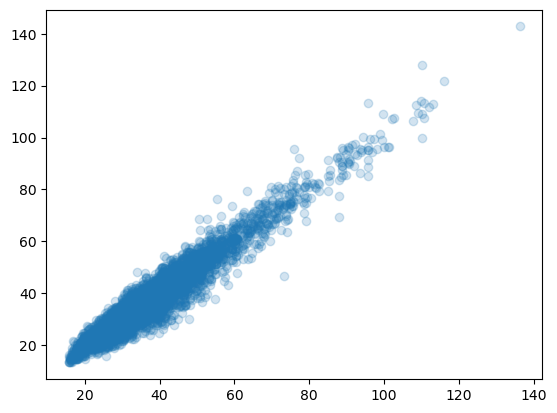

In [133]:
plt.scatter(scaleryyy.inverse_transform(y_pred_test.reshape(-1, 1)), y_test_inverse, alpha=0.2)

# TUNING for XGBOOST with 3 sigma

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
scaleryyy = MinMaxScaler()

columns_to_normalize = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
yyy = ['CorrBHT']

# Normalize specific columns independently
data_sigma_removed[columns_to_normalize] = scaler.fit_transform(data_sigma_removed[columns_to_normalize])
data_sigma_removed[yyy] = scaleryyy.fit_transform(data_sigma_removed[yyy])

In [51]:
# Define features and target
features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
geological_layers = data_sigma_removed.iloc[:, 52:101].values
geological_conds = data_sigma_removed.iloc[:, 101:150].values
mult = np.multiply(geological_layers, geological_conds)
np.nan_to_num(mult, 0)
X = np.concatenate((data_sigma_removed[features].values, mult), axis=1)
y = data_sigma_removed['CorrBHT'].values

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [53]:
# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [54]:
# max_depth (8), n_estimator (500), learning_rate=0.05, gamma=10, regression_lambda (10)

In [64]:
import xgboost as xgb

# Set the hyperparameters
max_depth = 10
n_estimators = 2000
learning_rate = 0.01
gamma = 0.1
regression_lambda = 10

# Create the XGBoost model
model = xgb.XGBRegressor(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    gamma=gamma,
    reg_lambda=regression_lambda,
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression tasks
    random_state=42  # Set a random seed for reproducibility
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

In [65]:
y_test_inverse = y_test.reshape(-1, 1)
y_test_inverse = scaleryyy.inverse_transform(y_test_inverse)

In [66]:
error = mean_squared_error(y_test_inverse, scaleryyy.inverse_transform(predictions.reshape(-1, 1)))
error

26.82896772570369

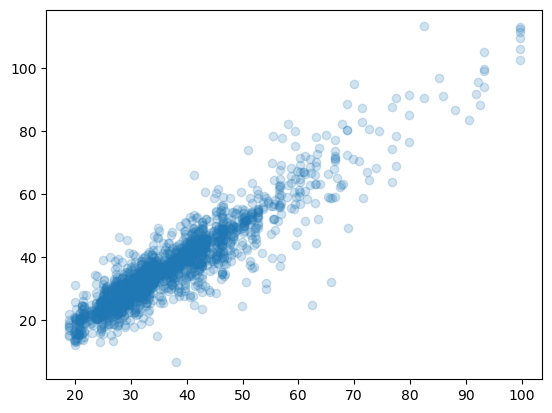

In [68]:
plt.scatter(scaleryyy.inverse_transform(predictions.reshape(-1, 1)), y_test_inverse, alpha=0.2)

# Tuning XGBOOST Hyperparameter tuning with IQR removal

In [83]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
scaleryyy = MinMaxScaler()

columns_to_normalize = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
yyy = ['CorrBHT']

# Normalize specific columns independently
data_iqr_removed[columns_to_normalize] = scaler.fit_transform(data_iqr_removed[columns_to_normalize])
data_iqr_removed[yyy] = scaleryyy.fit_transform(data_iqr_removed[yyy])

In [84]:
# Define features and target
features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
geological_layers = data_iqr_removed.iloc[:, 52:101].values
geological_conds = data_iqr_removed.iloc[:, 101:150].values
mult = np.multiply(geological_layers, geological_conds)
np.nan_to_num(mult, 0)
X = np.concatenate((data_iqr_removed[features].values, mult), axis=1)
y = data_iqr_removed['CorrBHT'].values

In [85]:
# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [86]:
import xgboost as xgb

# Set the hyperparameters
max_depth = 10
n_estimators = 2000
learning_rate = 0.01
gamma = 0.1
regression_lambda = 10

# Create the XGBoost model
model = xgb.XGBRegressor(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    gamma=gamma,
    reg_lambda=regression_lambda,
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression tasks
    random_state=42  # Set a random seed for reproducibility
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

In [87]:
y_test_inverse = y_test.reshape(-1, 1)
y_test_inverse = scaleryyy.inverse_transform(y_test_inverse)

In [88]:
error = mean_squared_error(y_test_inverse, scaleryyy.inverse_transform(predictions.reshape(-1, 1)))
error

19.736404599347757

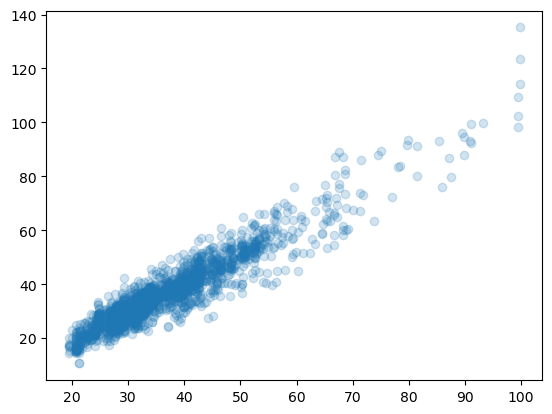

In [89]:
plt.scatter(scaleryyy.inverse_transform(predictions.reshape(-1, 1)), y_test_inverse, alpha=0.2)

# DNN with IQR

In [355]:
from keras import models
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [356]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
scaleryyy = MinMaxScaler()

columns_to_normalize = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
yyy = ['CorrBHT']

# Normalize specific columns independently
data_iqr_removed[columns_to_normalize] = scaler.fit_transform(data_iqr_removed[columns_to_normalize])
data_iqr_removed[yyy] = scaleryyy.fit_transform(data_iqr_removed[yyy])

In [357]:
# Define features and target
# features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
# geological_layers = data_iqr_removed.iloc[:, 52:101].values
# geological_conds = data_iqr_removed.iloc[:, 101:150].values
# mult = np.multiply(geological_layers, geological_conds)
# np.nan_to_num(mult, 0)
# X = np.concatenate((data_iqr_removed[features].values, mult), axis=1)
# y = data_iqr_removed['CorrBHT'].values

features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
X = data_iqr_removed[features].values
y = data_iqr_removed['CorrBHT'].values

In [358]:
# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [366]:
# Build neural network
model = models.Sequential()
model.add(Dense(50, input_shape=(4,)))
model.add(Dropout(0.005))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.001))
model.add(Dense(1))

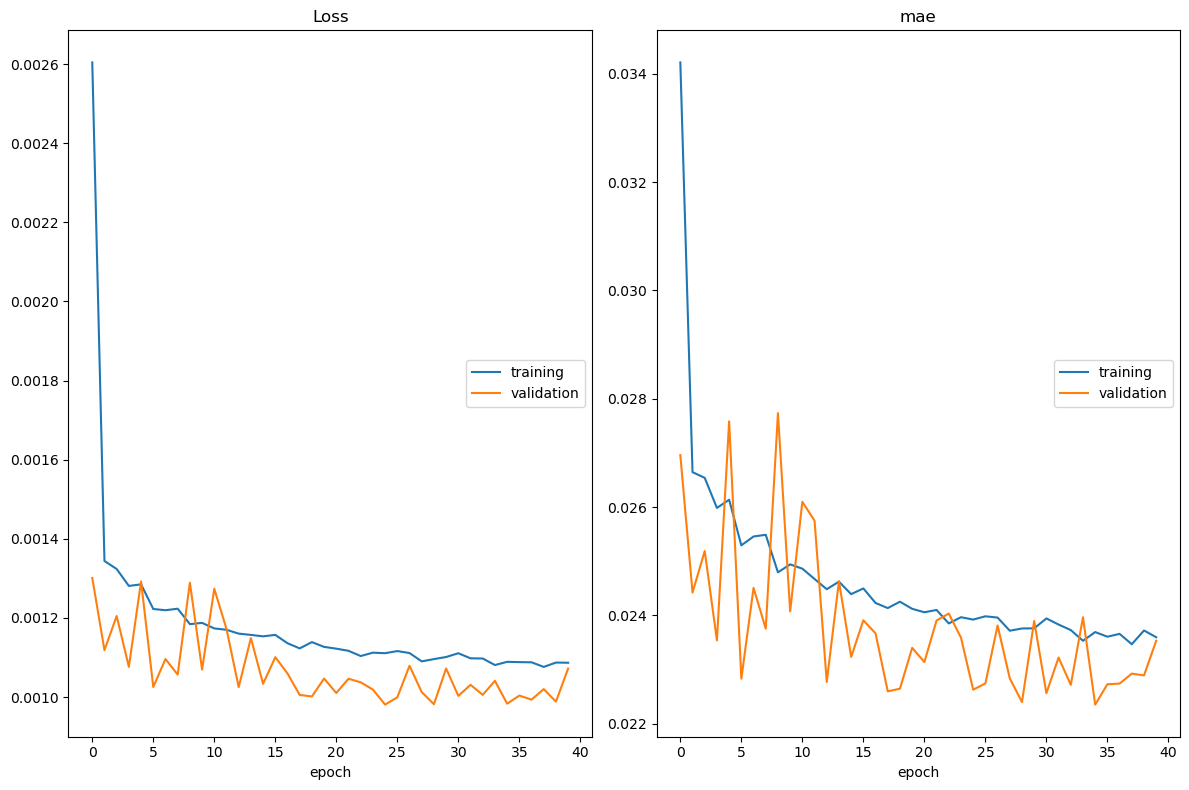

Loss
	training         	 (min:    0.001, max:    0.003, cur:    0.001)
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)
mae
	training         	 (min:    0.023, max:    0.034, cur:    0.024)
	validation       	 (min:    0.022, max:    0.028, cur:    0.024)
627/627 [==============================] - 3s 4ms/step - loss: 0.0011 - mae: 0.0236 - val_loss: 0.0011 - val_mae: 0.0235


In [367]:
# Compile model

import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

BATCH_SIZE = 25
EPOCHS = 40

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

# Train model
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[plot_losses],
          verbose=1,
          validation_data=(X_val, y_val))



In [368]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0011650006053969264
Test accuracy: 0.024154694750905037


In [372]:
predictions = model.predict(X_test)

245/245 [==============================] - 0s 2ms/step


In [373]:
y_test_inverse = y_test.reshape(-1, 1)
y_test_inverse = scaleryyy.inverse_transform(y_test_inverse)

In [374]:
error = mean_squared_error(y_test_inverse, scaleryyy.inverse_transform(predictions.reshape(-1, 1)))
error

21.64619681275613

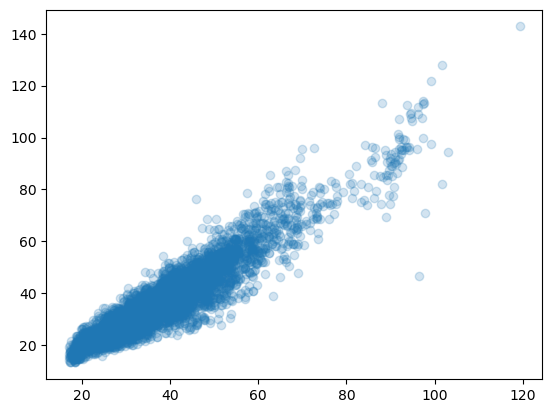

In [375]:
plt.scatter(scaleryyy.inverse_transform(predictions.reshape(-1, 1)), y_test_inverse, alpha=0.2)

# RF with IQR

In [68]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
scaleryyy = MinMaxScaler()

columns_to_normalize = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
yyy = ['CorrBHT']

# Normalize specific columns independently
data_iqr_removed[columns_to_normalize] = scaler.fit_transform(data_iqr_removed[columns_to_normalize])
data_iqr_removed[yyy] = scaleryyy.fit_transform(data_iqr_removed[yyy])

In [69]:
# Define features and target
features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
geological_layers = data_iqr_removed.iloc[:, 52:101].values
geological_conds = data_iqr_removed.iloc[:, 101:150].values
mult = np.multiply(geological_layers, geological_conds)
np.nan_to_num(mult, 0)
X = np.concatenate((data_iqr_removed[features].values, mult), axis=1)
y = data_iqr_removed['CorrBHT'].values

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [71]:
# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [72]:
# Assuming you're working with a classification problem, change to RandomForestRegressor for regression problems
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=2  
)

# Fit your model to the training data (X_train, y_train)
model.fit(X_train, y_train)

# After fitting, you can use the model to make predictions on new data
predictions = model.predict(X_test)

In [74]:
y_test_inverse = y_test.reshape(-1, 1)
y_test_inverse = scaleryyy.inverse_transform(y_test_inverse)

In [75]:
error = mean_squared_error(y_test_inverse, scaleryyy.inverse_transform(predictions.reshape(-1, 1)))
error

16.699573074482227

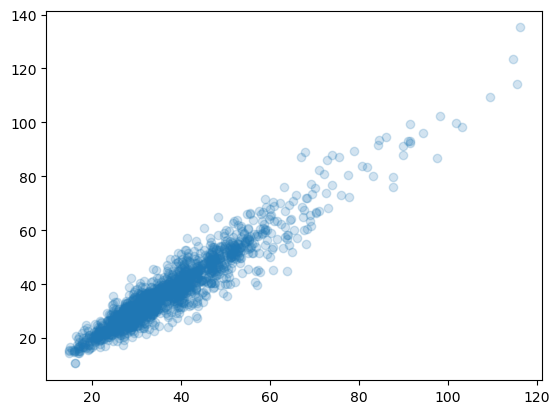

In [76]:
plt.scatter(scaleryyy.inverse_transform(predictions.reshape(-1, 1)), y_test_inverse, alpha=0.2)

# RF with 3 sigma

In [91]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
scaleryyy = MinMaxScaler()

columns_to_normalize = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
yyy = ['CorrBHT']

# Normalize specific columns independently
data_sigma_removed[columns_to_normalize] = scaler.fit_transform(data_sigma_removed[columns_to_normalize])
data_sigma_removed[yyy] = scaleryyy.fit_transform(data_sigma_removed[yyy])

In [92]:
# Define features and target
features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
geological_layers = data_sigma_removed.iloc[:, 52:101].values
geological_conds = data_sigma_removed.iloc[:, 101:150].values
mult = np.multiply(geological_layers, geological_conds)
np.nan_to_num(mult, 0)
X = np.concatenate((data_sigma_removed[features].values, mult), axis=1)
y = data_sigma_removed['CorrBHT'].values

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [94]:
# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [95]:
# Assuming you're working with a classification problem, change to RandomForestRegressor for regression problems
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=2  
)

# Fit your model to the training data (X_train, y_train)
model.fit(X_train, y_train)

# After fitting, you can use the model to make predictions on new data
predictions = model.predict(X_test)

In [96]:
y_test_inverse = y_test.reshape(-1, 1)
y_test_inverse = scaleryyy.inverse_transform(y_test_inverse)

In [97]:
error = mean_squared_error(y_test_inverse, scaleryyy.inverse_transform(predictions.reshape(-1, 1)))
error

23.073526702600017

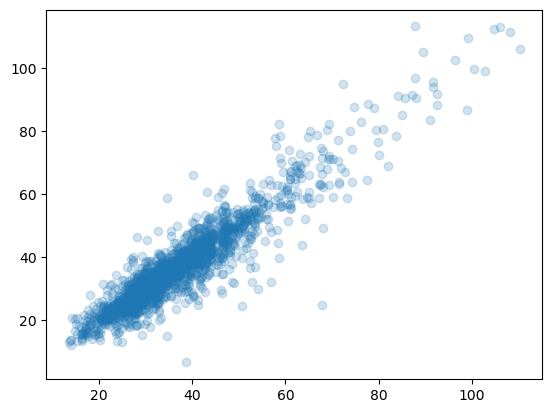

In [98]:
c

# DNN hyperparameter tuning with IQR

In [82]:
from keras import models
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split

In [83]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
scaleryyy = MinMaxScaler()

columns_to_normalize = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
yyy = ['CorrBHT']

# Normalize specific columns independently
data_iqr_removed[columns_to_normalize] = scaler.fit_transform(data_iqr_removed[columns_to_normalize])
data_iqr_removed[yyy] = scaleryyy.fit_transform(data_iqr_removed[yyy])

In [84]:
# Define features and target
# features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
# geological_layers = data_iqr_removed.iloc[:, 52:101].values
# geological_conds = data_iqr_removed.iloc[:, 101:150].values
# mult = np.multiply(geological_layers, geological_conds)
# np.nan_to_num(mult, 0)
# X = np.concatenate((data_iqr_removed[features].values, mult), axis=1)
# y = data_iqr_removed['CorrBHT'].values

features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp']
X = data_iqr_removed[features].values
y = data_iqr_removed['CorrBHT'].values

In [85]:
# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [158]:
# Define your neural network model as a function
def create_model(optimizer='adam', dropout_rate_1=0.005, dropout_rate_2=0.001, hidden_units=50, num_layers=2):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(4,)))
    model.add(Dropout(dropout_rate_1))
    
    for _ in range(num_layers):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate_2))
    
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model
# 32 60 3 100
# Hyperparameter values to search through
optimizers = ['adam', 'sgd']
dropout_rates_1 = [0.001, 0.005, 0.01]
dropout_rates_2 = [0.001, 0.005, 0.01]
hidden_units_list = [50, 100]
num_layers_list = [1, 2, 3]
epochs_list = [20, 40, 60]
batch_sizes = [16, 32, 64]

In [159]:
# Best hyperparameters and corresponding score
best_params = None
best_score = float('-inf')

# Loop through all combinations of hyperparameters
for optimizer in optimizers:
    for dropout_rate_1 in dropout_rates_1:
        for dropout_rate_2 in dropout_rates_2:
            for hidden_units in hidden_units_list:
                for num_layers in num_layers_list:
                    for epochs in epochs_list:
                        for batch_size in batch_sizes:
                            # Create and compile the model
                            model = create_model(optimizer, dropout_rate_1, dropout_rate_2, hidden_units, num_layers)
                            
                            # Train the model
                            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                                                            
                            # Evaluate the model
                            _, mean_absolute_error = model.evaluate(X_val, y_val, verbose=0)
                            
                            print(mean_absolute_error)
                            
                            # Check if the current combination is better than the best
                            if mean_absolute_error < best_score:
                                best_score = mean_absolute_error
                                best_params = {'optimizer': optimizer, 'dropout_rate_1': dropout_rate_1, 'dropout_rate_2': dropout_rate_2, 'hidden_units': hidden_units, 'num_layers': num_layers, 'epochs': epochs, 'batch_size': batch_size}

# Print the best parameters and the corresponding mean test score
print("Best Parameters: ", best_params)
print("Best Mean Test Score: ", best_score)

0.02365449070930481
0.0246709156781435
0.023484477773308754
0.02317143604159355
0.024465244263410568
0.02341652289032936
0.022127090021967888
0.02196325734257698
0.022990845143795013
0.02250474877655506
0.0221723522990942
0.023295825347304344
0.022599633783102036
0.02258259244263172
0.022903988137841225
0.021775245666503906
0.022107595577836037
0.021886397153139114
0.02181502804160118
0.02270274981856346
0.02221754565834999
0.022850504145026207
0.022102175280451775
0.02345137670636177
0.022197574377059937
0.022731419652700424
0.02149573713541031
0.02380891516804695
0.024173371493816376
0.023441221565008163
0.023928411304950714
0.02320426143705845
0.025781963020563126
0.023653939366340637
0.022437164559960365
0.02228309027850628
0.022625349462032318
0.02246948517858982
0.02255931869149208
0.021533552557229996
0.022085975855588913
0.022291485220193863
0.022649705410003662
0.02211499959230423
0.0221953634172678
0.02269570343196392
0.024071136489510536
0.02291695773601532
0.022343497723340

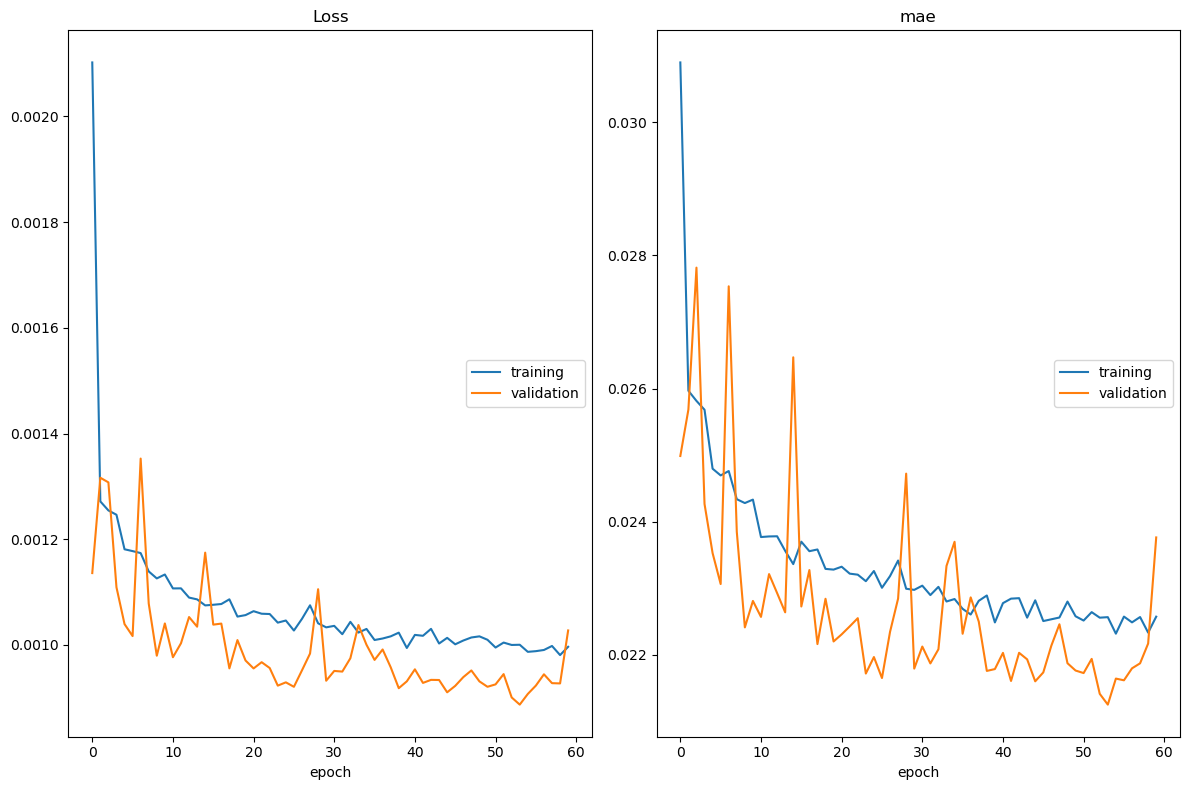

Loss
	training         	 (min:    0.001, max:    0.002, cur:    0.001)
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)
mae
	training         	 (min:    0.022, max:    0.031, cur:    0.023)
	validation       	 (min:    0.021, max:    0.028, cur:    0.024)
490/490 [==============================] - 3s 5ms/step - loss: 9.9650e-04 - mae: 0.0226 - val_loss: 0.0010 - val_mae: 0.0238
0.023764384910464287


In [86]:
# Define your neural network model as a function

import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

model = Sequential()
model.add(Dense(100, input_shape=(4,)))
model.add(Dropout(0.001))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.001))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.001))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.001))
    
model.add(Dense(1))
    
model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])

model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1, callbacks=[plot_losses], validation_data=(X_val, y_val))

# Evaluate the model
_, mean_absolute_error = model.evaluate(X_val, y_val, verbose=0)
                            
print(mean_absolute_error)
    
# 32 60 3 100
# Hyperparameter values to search through
# optimizers = ['adam', 'sgd']
# dropout_rates_1 = [0.001, 0.005, 0.01]
# dropout_rates_2 = [0.001, 0.005, 0.01]
# hidden_units_list = [50, 100]
# num_layers_list = [1, 2, 3]
# epochs_list = [20, 40, 60]
# batch_sizes = [16, 32, 64]

In [87]:
# After fitting, you can use the model to make predictions on new data
predictions = model.predict(X_test)

245/245 [==============================] - 1s 2ms/step


In [88]:
y_test_inverse = y_test.reshape(-1, 1)
y_test_inverse = scaleryyy.inverse_transform(y_test_inverse)

In [89]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test_inverse, scaleryyy.inverse_transform(predictions.reshape(-1, 1))) # MSE
error

20.66997283585974

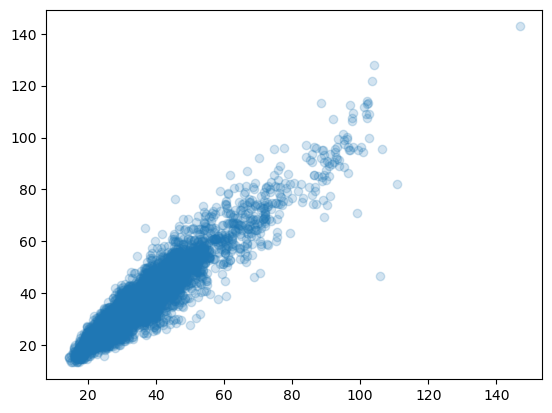

In [90]:
plt.scatter(scaleryyy.inverse_transform(predictions.reshape(-1, 1)), y_test_inverse, alpha=0.2)